In [39]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
import numpy as np
import random
import math
import matplotlib.pyplot as plt

[[-1. ]
 [ 1. ]
 [ 0.1]
 [-0.1]] [[1]
 [1]
 [0]
 [0]]


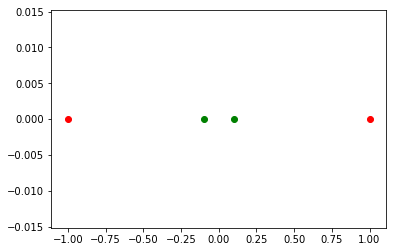

In [95]:

random.seed(3)

def rand_cluster(n,c,r):
    """returns n random points in disk of radius r centered at c"""
    x = c
    points = []
    for i in range(n):
        theta = 2*math.pi*random.random()
        s = r*random.random()
        points.append([x+s*math.cos(theta)])
    return points

def rand_clusters(k,n,r, a,b,c,d):
    """return k clusters of n points each in random disks of radius r
    where the centers of the disk are chosen randomly in [a,b]x[c,d]"""
    clusters = []
    for _ in range(k):
        x = a + (b-a)*random.random()
        y = c + (d-c)*random.random()
        clusters.extend(rand_cluster(n,x,r))
    return clusters

n = 2
X = rand_clusters(2,n,0.8,-1,1,-1,1)
data = np.array(X)
label = np.transpose(np.array([[1]*n + [0]*n]))

# label = np.array([1]*n + [0]*n)
data = []
label = []
data.append([-1])
data.append([1])
data.append([0.1])
data.append([-0.1])
label.append([1])
label.append([1])
label.append([0])
label.append([0])
data = np.array(data)
label = np.array(label)
print (data, label)

plt.scatter(data[:n], [0]*n, color=['red'])
plt.scatter(data[n:], [0]*n, color=['green'])
plt.show()

In [105]:
# tf.reset_default_graph()

# def weight_variable(shape, name):
#     initial = tf.truncated_normal(shape=shape, stddev=0.1)
#     return tf.get_variable(name=name, initializer=initial)

# def bias_variable(shape, name):
#     initial = tf.constant(0.1, shape=shape)
#     return tf.get_variable(name=name, initializer=initial)


x = tf.placeholder(tf.float32, [None, 1])
y_ = tf.placeholder(tf.float32, [None, 1])


n_input = 1
n_hidden = 2
n_output = 1
lmd = 0

parameters = tf.Variable(tf.concat([tf.truncated_normal([n_input * n_hidden]), tf.zeros([n_hidden]),\
                                    tf.truncated_normal([n_hidden * n_output]), tf.zeros([n_output]),\
                                   ], 0))

idx_from = 0 
weights1 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_input*n_hidden]), [n_input, n_hidden])
idx_from = idx_from + n_input*n_hidden
biases1 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_hidden]), [n_hidden])
hidden = tf.nn.relu(tf.matmul(x, weights1) + biases1)

idx_from = idx_from + n_hidden
weights2 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_hidden*n_output]), [n_hidden, n_output])
idx_from = idx_from + n_hidden*n_output
biases2 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_output]), [n_output])
y = tf.nn.relu(tf.matmul(hidden, weights2) + biases2)

loss = tf.reduce_mean(tf.reduce_sum(tf.pow(y_ - y, 2), reduction_indices=[1])) #I also tried simply tf.nn.l2_loss(y_ - y)

lr = tf.placeholder(tf.float32, shape=[])
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
grads_and_vars = optimizer.compute_gradients(loss)
grad = tf.gradients(loss, parameters)
hess = tf.hessians(loss, parameters)
train_step = optimizer.apply_gradients(grads_and_vars)

In [106]:

def get_accuracy():
    pred = sess.run(y, feed_dict={x: data, y_: label})    
    match = [(pred[i] - 0.5) * (label[i] - 0.5) > 0  for i in range(n*2)]
    acc = sum(match)*1./2/n
    return acc[0]

def get_norm_grad():
    nng = 0.
    for gv in grad:
#         print(str(sess.run(gv[0], feed_dict={x: data, y_: label})) + " - " + gv[1].name)
        g = sess.run(gv, feed_dict={x: data, y_: label})
#         print (g)
        nng += np.linalg.norm(g) ** 2
    return np.sqrt(nng)
    
     
def displayH(a):
    a = np.array(a[0])
#     print ("Matrix["+("%d" %a.shape[0])+"]["+("%d" %a.shape[1])+"]")
    rows = a.shape[0]
    cols = a.shape[1]
    for i in range(0, rows):
        for j in range(0, cols):
            print("%0.2g " %a[i,j], end="")
        print ()
    print ()


In [107]:
sess = tf.InteractiveSession()
l = 1e-3
dic = {}

for r in range(100):
    
    flag = 1
    tf.global_variables_initializer().run()
    w = sess.run([parameters], feed_dict={x: data, y_: label, lr: l})
    dic[r] = w
 
    for i in range(100):
        sess.run(train_step, feed_dict={x: data, y_: label, lr: l})
        nng = get_norm_grad()
        if nng < 1e-4:
            flag = 1
            break

    if flag == 1:
        v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label, lr: l})    
        nng = get_norm_grad()
        eigs = sorted(np.linalg.eigvals(H)[0])
        print (r)
        print("Epoch {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g}, nnw {:.4g}, high_eig {:.4g}, low_eig {:.4g}."\
                .format(i+1, get_accuracy()*100, v, nng, np.linalg.norm(w[:n_hidden]), max(eigs), min(eigs) ))
        
#         print (w)
#             h = sess.run([y], feed_dict={x: data, y_: label})    
#         print (h)
sess.close() 

0
Epoch 1, accuracy 50.00%, loss 0.500000, nng 0, nnw 0.1685, high_eig 0, low_eig 0.
1
Epoch 100, accuracy 75.00%, loss 0.272734, nng 0.2352, nnw 1.841, high_eig 1.999, low_eig -0.01816.
2
Epoch 100, accuracy 75.00%, loss 0.142793, nng 0.5006, nnw 1.594, high_eig 2.765, low_eig -0.276.
3
Epoch 1, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.404, high_eig 0, low_eig 0.
4
Epoch 1, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.034, high_eig 0, low_eig 0.
5
Epoch 100, accuracy 50.00%, loss 0.278486, nng 0.7663, nnw 1.134, high_eig 2.276, low_eig -0.4625.
6
Epoch 100, accuracy 75.00%, loss 0.247128, nng 0.7348, nnw 1.472, high_eig 4.136, low_eig -0.421.
7
Epoch 100, accuracy 75.00%, loss 0.383415, nng 0.9507, nnw 1.376, high_eig 4.476, low_eig -0.4531.
8
Epoch 1, accuracy 50.00%, loss 0.500000, nng 0, nnw 0.6419, high_eig 0, low_eig 0.
9
Epoch 1, accuracy 50.00%, loss 0.500000, nng 0, nnw 0.3007, high_eig 0, low_eig 0.
10
Epoch 100, accuracy 50.00%, loss 0.337189, nng 0.7961, nnw 0.3766, hig

86
Epoch 1, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.604, high_eig 0, low_eig 0.
87
Epoch 1, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.212, high_eig 0, low_eig 0.
88
Epoch 100, accuracy 75.00%, loss 0.272626, nng 0.2651, nnw 2.217, high_eig 2.302, low_eig -0.01386.
89
Epoch 100, accuracy 75.00%, loss 0.293580, nng 0.2958, nnw 1.052, high_eig 1.903, low_eig -0.07098.
90
Epoch 100, accuracy 75.00%, loss 0.271034, nng 0.2025, nnw 1.776, high_eig 1.954, low_eig -0.02178.
91
Epoch 100, accuracy 50.00%, loss 0.348077, nng 0.8726, nnw 0.8063, high_eig 2.772, low_eig -0.4565.
92
Epoch 100, accuracy 50.00%, loss 0.335215, nng 0.4072, nnw 1.024, high_eig 1.883, low_eig -0.1235.
93
Epoch 100, accuracy 75.00%, loss 0.262775, nng 0.6642, nnw 1.208, high_eig 4.029, low_eig -0.2155.
94
Epoch 100, accuracy 75.00%, loss 0.447905, nng 1.22, nnw 1.419, high_eig 5.217, low_eig -0.6208.
95
Epoch 1, accuracy 50.00%, loss 0.500000, nng 0, nnw 1.83, high_eig 0, low_eig 0.
96
Epoch 100, accuracy 50.00%,

3.19:

Relu is helpful to obtain flat region. For example, zero is not a first order stationary point while using sigmoid, but indeed is while using relu.
    
For sigmoid, point far away from 0 tends to have tiny gradient.


In [123]:
sol = {}

In [127]:
idx = 45
print (dic[idx][0])

[-0.54967874  0.46465215  0.          0.          0.85924828  1.13367045
  0.        ]


In [128]:
private_init = parameters.assign(dic[idx][0])
sess = tf.InteractiveSession()
l = 5e-1

tf.global_variables_initializer().run()
sess.run(private_init)    
v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label, lr: l})    
nng = get_norm_grad()
# print (sess.run(grad[0], feed_dict={x: data, y_: label}))

for i in range(100):
    sess.run(train_step, feed_dict={x: data, y_: label, lr: l})
    v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label, lr: l})    
    nng = get_norm_grad()
    eigs = sorted(np.linalg.eigvals(H)[0])
print("Epoch {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g}, nnw {:.4g}, high_eig {:.4g}, low_eig {:.4g}."\
            .format(i+1, get_accuracy()*100, v, nng, np.linalg.norm(w[:n_hidden]), max(eigs), min(eigs) ))
#     print (sess.run(grad[0], feed_dict={x: data, y_: label}))
#     print (w)
sol[idx] = w
print (sol[idx])
sess.close() 

Epoch 100, accuracy 100.00%, loss 0.000000, nng 8.756e-08, nnw 1.312, high_eig 3.455, low_eig -3.519e-08.
[-0.9774105   0.87449503 -0.09644938 -0.08832376  1.13679051  1.27385521
 -0.00146833]


In [129]:
sol

{15: array([ 1.75133431, -1.00075877, -0.07483343, -0.01163835,  0.65504843,
         1.11026835, -0.09818926], dtype=float32),
 45: array([-0.9774105 ,  0.87449503, -0.09644938, -0.08832376,  1.13679051,
         1.27385521, -0.00146833], dtype=float32)}

In [142]:
w0 = dic[15][0]
print (w0)
private_init = parameters.assign(w0)
sess = tf.InteractiveSession()
l = 5e-1

tf.global_variables_initializer().run()
sess.run(private_init)    
v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label, lr: l})    
nng = get_norm_grad()
# print (sess.run(grad[0], feed_dict={x: data, y_: label}))

for i in range(100):
    sess.run(train_step, feed_dict={x: data, y_: label, lr: l})
    v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label, lr: l})    
    nng = get_norm_grad()
    eigs = sorted(np.linalg.eigvals(H)[0])
print("Epoch {}, accuracy {:.2f}%, loss {:.6g}, nng {:.4g}, nnw {:.4g}, high_eig {:.4g}, low_eig {:.4g}."\
            .format(i+1, get_accuracy()*100, v, nng, np.linalg.norm(w[:n_hidden]), max(eigs), min(eigs) ))
print (w)
w[0] += 1e-0
private_init = parameters.assign(w)
sess.run(private_init)    
nng = get_norm_grad()
print("Epoch {}, accuracy {:.2f}%, loss {:.6g}, nng {:.4g}, nnw {:.4g}, high_eig {:.4g}, low_eig {:.4g}."\
            .format(i+1, get_accuracy()*100, v, nng, np.linalg.norm(w[:n_hidden]), max(eigs), min(eigs) ))

sess.close() 

[ 1.79397285 -0.81013817  0.          0.          0.74770951  0.9456349   0.        ]
Epoch 100, accuracy 100.00%, loss 7.56339e-15, nng 7.985e-08, nnw 2.017, high_eig 3.446, low_eig -9.984e-09.
[ 1.75133431 -1.00075877 -0.07483343 -0.01163835  0.65504843  1.11026835
 -0.09818926]
Epoch 100, accuracy 100.00%, loss 7.56339e-15, nng 0.9949, nnw 2.928, high_eig 3.446, low_eig -9.984e-09.


## 3.20:
    This example shows, initialization is more important than optimization, to reach 100% training accuracy. 
    
    Also, for 1d data, weights are not important. It is bias that works. It may be possible to visualize the landscape since there are only 3 bias.